In [1]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [2]:
GRAIN_TYPE = 'Combined_Grains'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
df = df.groupby('Grain Type').head(366)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
                  #  'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Grain Type']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [3]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Grain Type'].nunique()
varieties = df_targets['Grain Type'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'Grain Type' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Grain Type'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


In [4]:
# Convert the one-hot encoded labels back to integer encoded labels for stratification
y_integers = np.argmax(y_one_hot, axis=1)

# Perform stratified train-test split on the data
X_trainVal, X_test, y_trainVal_integer, y_test_integer = train_test_split(
    dataset_x, y_integers, test_size=0.20, stratify=y_integers, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_trainVal = tf.one_hot(y_trainVal_integer, depth).numpy()
y_test = tf.one_hot(y_test_integer, depth).numpy()

# Stratified split for the validation set
X_train, X_val, y_train_integer, y_val_integer = train_test_split(
    X_trainVal, y_trainVal_integer, test_size=0.15, stratify=y_trainVal_integer, random_state=42
)

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_train = tf.one_hot(y_train_integer, depth).numpy()
y_val = tf.one_hot(y_val_integer, depth).numpy()


In [5]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from hyperopt import space_eval

# Define the search space
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 5]),
    'units_layer': hp.choice('units_layer', [64, 128, 256, 300,400,512]),
    'batch_size': hp.choice('batch_size', [8,16, 32, 64, 128]),
    'epochs': hp.quniform('epochs', 150, 800, 50),  # Range of epochs from 150 to 800 with steps of 50
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}
metrics = ['accuracy']  # General accuracy for all classes

# Add precision and recall for each class
for i in range(depth):
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=f'precision_class_{i}'))
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=f'recall_class_{i}'))

# Define the objective function
def objective(params):
    model = Sequential()
    model.add(Dense(int(params['units_layer']), activation='relu'))
    for _ in range(int(params['num_layers']) - 1):
        model.add(Dense(int(params['units_layer']), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=[metrics])
    
    history = model.fit(X_train, y_train, 
                        epochs=int(params['epochs']),
                        batch_size=int(params['batch_size']),
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = np.max(history.history['val_accuracy'])
    return {'loss': -best_val_acc, 'params': params, 'status': STATUS_OK, 'best_epoch': best_epoch}

# Run the hyperparameter search using the tpe algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=40,
            trials=trials)

# Extract the best hyperparameters
best_params = space_eval(space, best)
print('Best parameters:', best_params)

# Train and save the best model
best_model = Sequential()
best_model.add(Dense(best_params['units_layer'], activation='relu'))
for _ in range(best_params['num_layers'] - 1):
    best_model.add(Dense(best_params['units_layer'], activation='relu'))
best_model.add(Dense(5, activation='softmax'))

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='categorical_crossentropy',
                   metrics=[metrics])

history = best_model.fit(X_train, y_train,
               epochs=int(best_params['epochs']),
               batch_size=int(best_params['batch_size']),
               validation_data=(X_val, y_val),
               verbose=1)

best_model.save("bestClassificationModelBAYES")


100%|██████████| 40/40 [1:24:31<00:00, 126.78s/trial, best loss: -0.9727272987365723]
Best parameters: {'batch_size': 16, 'epochs': 700.0, 'learning_rate': 0.006738550781435328, 'num_layers': 5, 'units_layer': 64}
Epoch 1/700
78/78 [==============================] - 1s 8ms/step - loss: 1.0758 - accuracy: 0.4992 - precision_class_0: 0.6000 - recall_class_0: 0.2150 - precision_class_1: 0.8583 - recall_class_1: 0.3515 - precision_class_2: 0.8328 - recall_class_2: 0.8498 - precision_class_3: 0.4516 - recall_class_3: 0.0479 - precision_class_4: 0.3750 - recall_class_4: 0.0102 - val_loss: 0.9094 - val_accuracy: 0.5318 - val_precision_class_0: 0.0000e+00 - val_recall_class_0: 0.0000e+00 - val_precision_class_1: 0.9167 - val_recall_class_1: 0.5000 - val_precision_class_2: 0.9302 - val_recall_class_2: 0.9091 - val_precision_class_3: 0.6667 - val_recall_class_3: 0.0909 - val_precision_class_4: 0.0000e+00 - val_recall_class_4: 0.0000e+00
Epoch 2/700
78/78 [==============================] - 0s 5ms

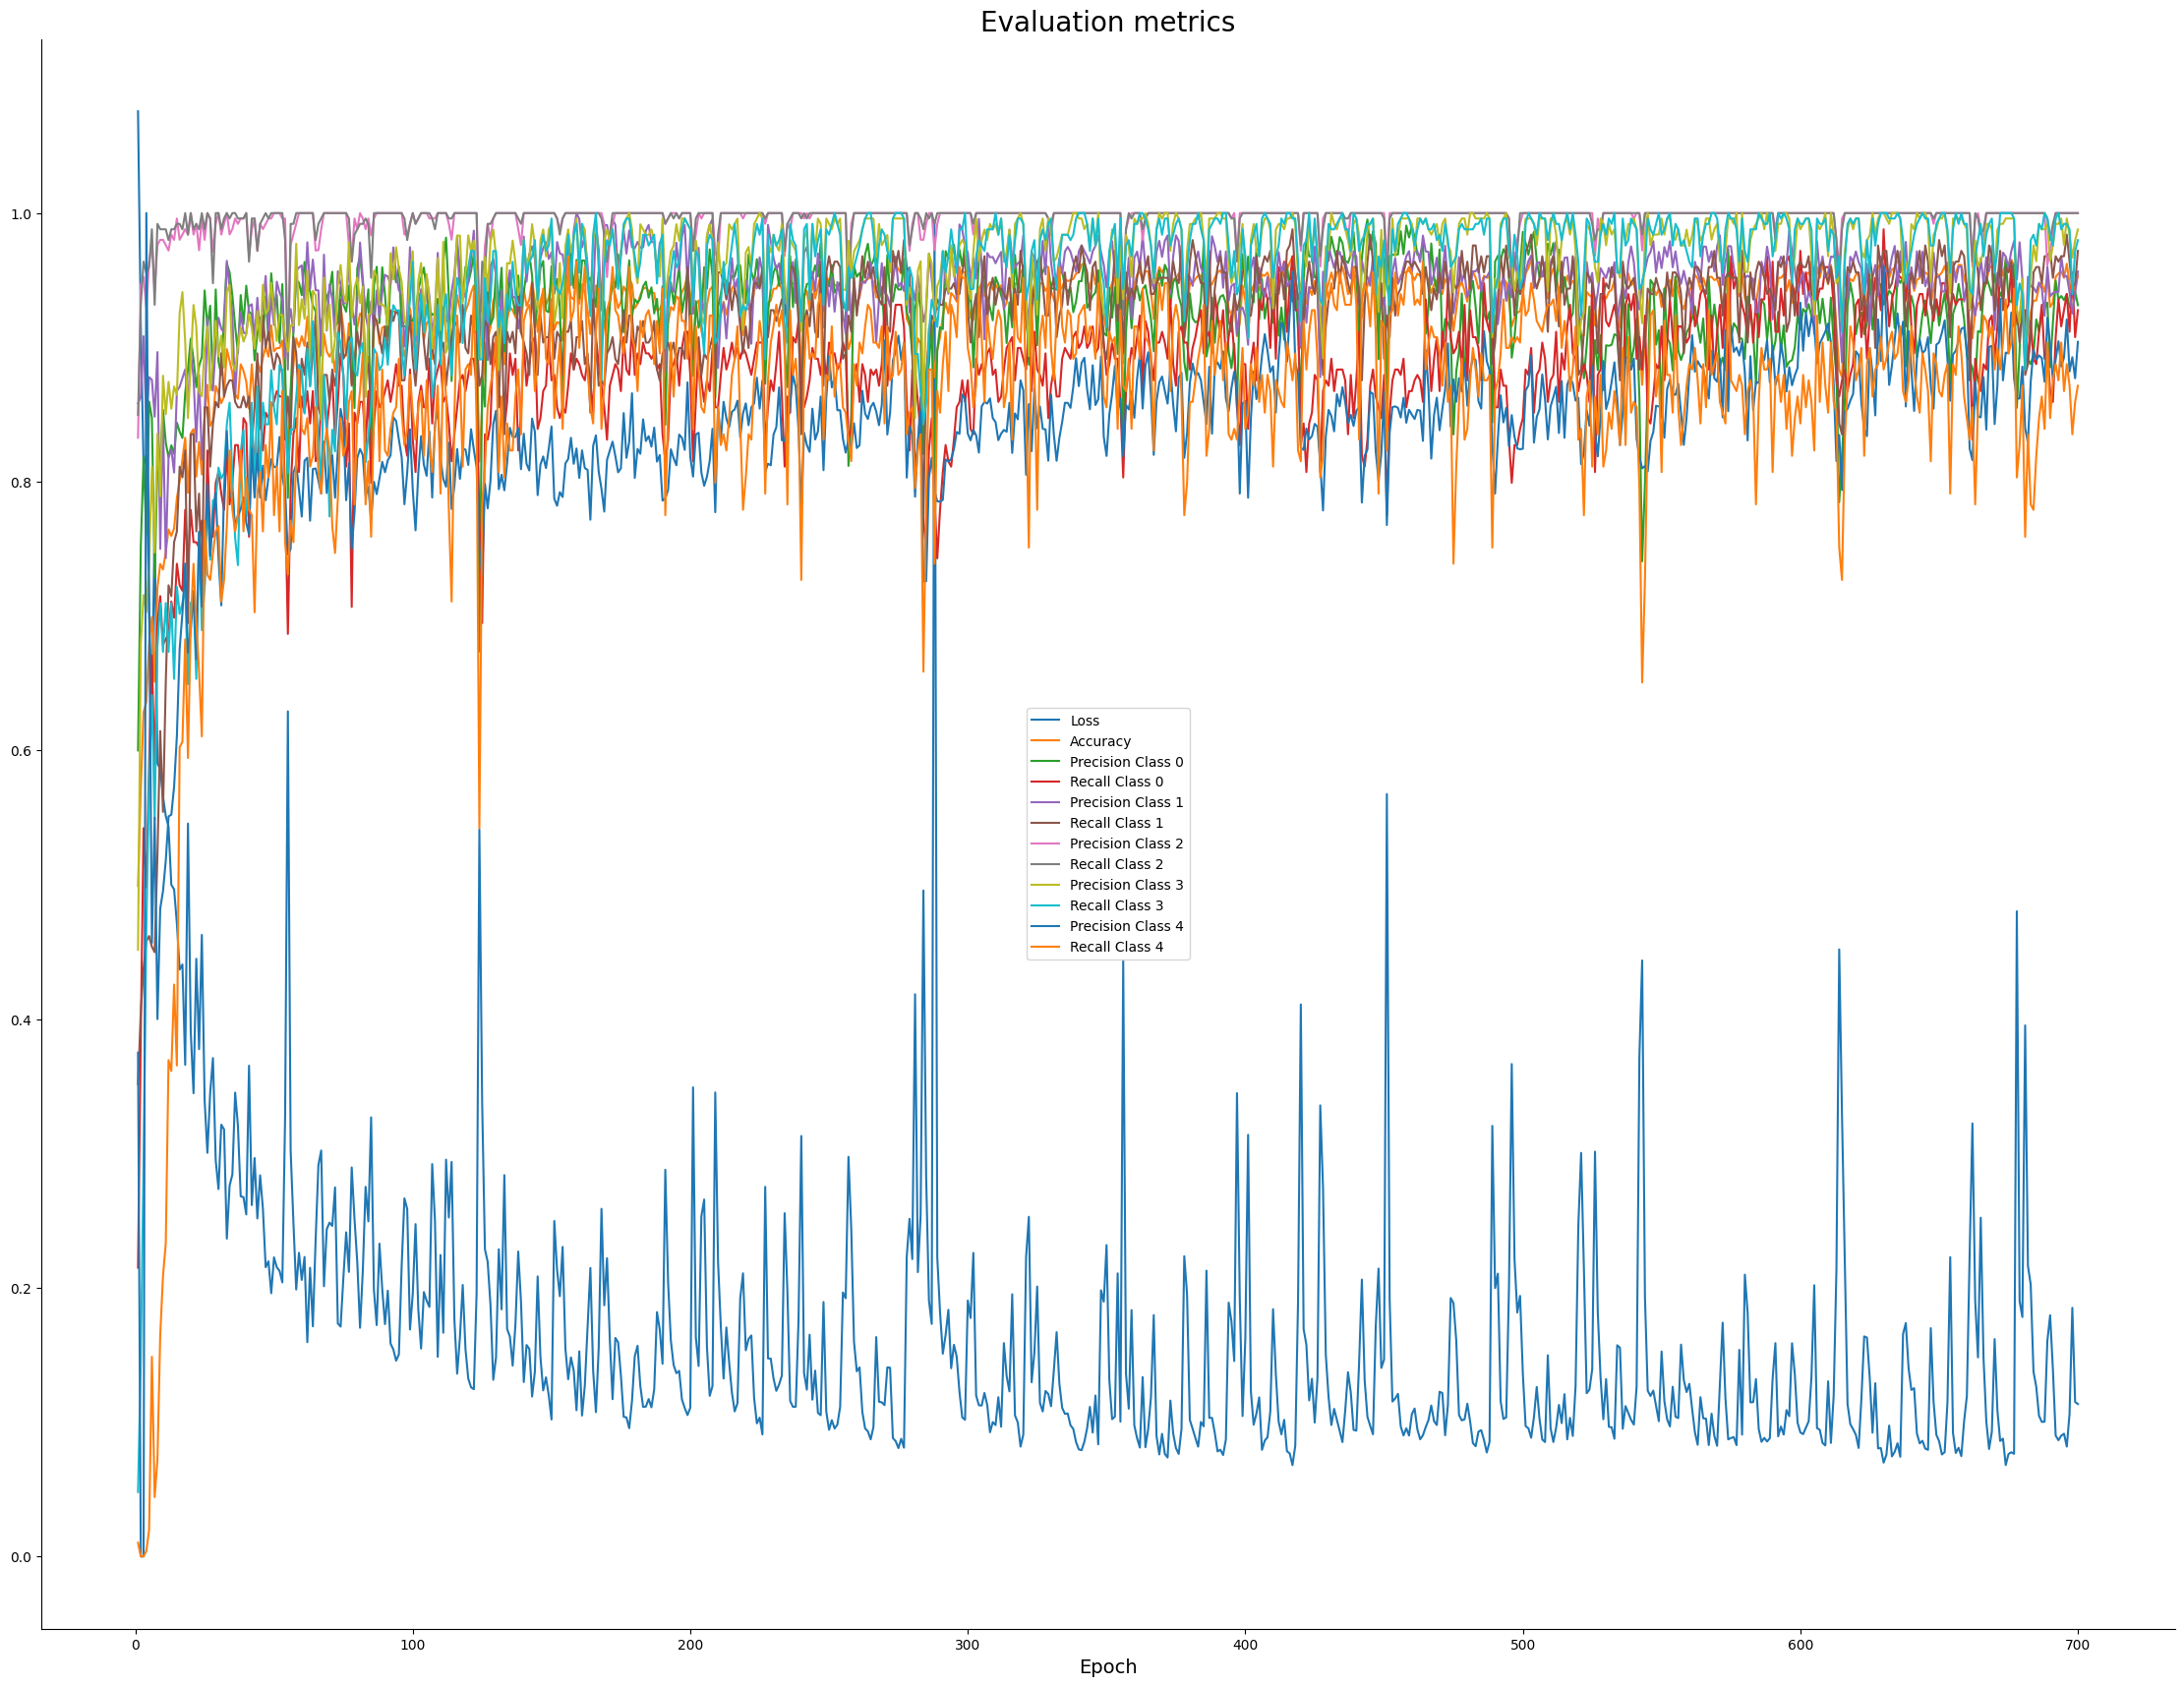

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
trial_timeout=30
rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [10]:
def print_dataset_split(y_train_integer,y_test_integer,y_val_integer):
    # Create a DataFrame for the training set class distribution
    train_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_train_integer)),
        'Train': np.bincount(y_train_integer)
    })

    # Create a DataFrame for the balanced test set class distribution
    test_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_test_integer)),
        'Test': np.bincount(y_test_integer)
    })
    val_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_val_integer)),
        'Val': np.bincount(y_val_integer)
    })
    # Merge the two DataFrames on Class Name
    acombined_counts = pd.merge(train_counts, test_counts, on='Class Name', how='outer').fillna(0)
    combined_counts = pd.merge(acombined_counts, val_counts, on='Class Name', how='outer').fillna(0)

    # Converts to integer type
    combined_counts['Train'] = combined_counts['Train'].astype(int)
    combined_counts['Test'] = combined_counts['Test'].astype(int)
    combined_counts['Val'] = combined_counts['Val'].astype(int)

    # Set display options for pandas
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)

    # Print combined class counts in a tabular format
    print(combined_counts.to_string(index=False, justify='right'))

# Evaluate the model on the test data
test_loss, test_accuracy, *test_metrics = best_model.evaluate(X_test, y_test,verbose=0)
y_pred = best_model.predict(X_test,verbose=0)

# Assuming the order of metrics is consistent with how we added them:
# test_metrics[0] -> precision_class_0, test_metrics[1] -> recall_class_0, etc.
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

num_classes = 5  # Update this with the actual number of classes you have
class_names = label_encoder.inverse_transform(np.unique(y_train_integer))

def compute_confusion_matrix(true, pred):
    classes = np.unique(true)
    conf_mat = [[0] * len(classes) for i in range(len(classes))]
    for i in range(len(true)):
        conf_mat[pred[i]][true[i]]+=1
    print("       Actual")
    print("      _",end="")
    for item in classes:
        print("____",end="")
    print()
    print("pred  |", end=" "),
    for item in classes:
        print("{:^3}".format(item), end=" ")
    print()
    for item in classes:
        print("{:^6}|".format(item), end=" ")
        for item2 in classes:
            print("{:^3}".format(conf_mat[item][item2]), end="|")
        print()
def compute_metrics_per_class(true, pred,test_metrics):
    classes = np.unique(true)
    conf_mat = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(true)):
        conf_mat[pred[i], true[i]] += 1

    num_classes = len(classes)
    max_class_name_length = max(len(name) for name in class_names)
    
    total_precision = 0
    total_recall = 0
    total_accuracy = 0

    for i in range(num_classes):
        precision = float(test_metrics[2 * i])  # Even indices for precision
        recall = float(test_metrics[2 * i + 1])  # Odd indices for recall
        accuracy = float(conf_mat[i, i]) / np.sum(conf_mat[:, i])  # Calculate accuracy for class i
        
        total_precision += precision
        total_recall += recall
        total_accuracy += accuracy

        print(f"{class_names[i]:<{max_class_name_length}} | Precision: {precision:.3f} | Recall: {recall:.3f} | Accuracy: {accuracy:.3f}")

    # Calculate and print the averages
    avg_precision = total_precision / num_classes
    avg_recall = total_recall / num_classes
    avg_accuracy = total_accuracy / num_classes
    print(f"\nAvg Precision: {avg_precision:.3f} | Avg Recall: {avg_recall:.3f} | Avg Accuracy: {avg_accuracy:.3f}")

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_nums = np.argmax(y_test, axis=1)
y_val_nums = np.argmax(y_val, axis=1)

print_dataset_split(y_train_integer,y_test_integer,y_val_integer)
print()
print("=================================================================")

compute_confusion_matrix(y_test_nums.tolist(),y_pred_labels.tolist())
print()
print("=================================================================")
compute_metrics_per_class(y_test_nums.tolist(),y_pred_labels.tolist(),test_metrics)
print("HYPERPARAMS: LR:",best_params['learning_rate']," EPOCH:",best_params['epochs']," BATCH:",best_params['batch_size'])
print("=================================================================")


Class Name  Train  Test  Val
    Barley    249    73   44
      Corn    249    73   44
      Oats    249    73   44
   Sorghum    248    74   44
     Wheat    249    73   44

       Actual
      _____________________
pred  |  0   1   2   3   4  
  0   | 67 | 0 | 0 | 0 | 8 |
  1   |  0 |73 | 0 | 0 | 1 |
  2   |  0 | 0 |73 | 0 | 0 |
  3   |  1 | 0 | 0 |74 | 1 |
  4   |  5 | 0 | 0 | 0 |63 |

Barley  | Precision: 0.893 | Recall: 0.918 | Accuracy: 0.918
Corn    | Precision: 0.986 | Recall: 0.986 | Accuracy: 1.000
Oats    | Precision: 1.000 | Recall: 1.000 | Accuracy: 1.000
Sorghum | Precision: 0.974 | Recall: 1.000 | Accuracy: 1.000
Wheat   | Precision: 0.925 | Recall: 0.849 | Accuracy: 0.863

Avg Precision: 0.956 | Avg Recall: 0.951 | Avg Accuracy: 0.956
HYPERPARAMS: LR: 0.006738550781435328  EPOCH: 700.0  BATCH: 16
